In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [5]:
# Transform: Convert to tensor + normalize pixels (0-1 range)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # mean=0.5, std=0.5
])

train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=1000, shuffle=False)


In [6]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = x.view(-1, 28*28)       # flatten image
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [7]:
class SimpleNN_BN(nn.Module):
    def __init__(self):
        super(SimpleNN_BN, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.bn1(self.fc1(x)))   # Apply BN after layer
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x


In [8]:
def train_model(model, train_loader, test_loader, epochs=5):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    train_losses, test_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        # Evaluate on test data
        model.eval()
        correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                output = model(data)
                pred = output.argmax(dim=1)
                correct += pred.eq(target).sum().item()
        
        accuracy = 100. * correct / len(test_loader.dataset)
        test_accuracies.append(accuracy)

        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.2f}%")
    
    return train_losses, test_accuracies


In [9]:
model_no_bn = SimpleNN()
losses_no_bn, acc_no_bn = train_model(model_no_bn, train_loader, test_loader, epochs=10)


Epoch 1/10, Loss: 0.3360, Test Accuracy: 93.65%
Epoch 2/10, Loss: 0.1521, Test Accuracy: 96.10%
Epoch 3/10, Loss: 0.1095, Test Accuracy: 95.58%
Epoch 4/10, Loss: 0.0882, Test Accuracy: 96.51%
Epoch 5/10, Loss: 0.0743, Test Accuracy: 96.88%
Epoch 6/10, Loss: 0.0652, Test Accuracy: 97.37%
Epoch 7/10, Loss: 0.0572, Test Accuracy: 97.13%
Epoch 8/10, Loss: 0.0527, Test Accuracy: 97.74%
Epoch 9/10, Loss: 0.0457, Test Accuracy: 97.57%
Epoch 10/10, Loss: 0.0416, Test Accuracy: 97.34%


In [ ]:
model_with_bn = SimpleNN_BN()
losses_bn, acc_bn = train_model(model_with_bn, train_loader, test_loader, epochs=10)


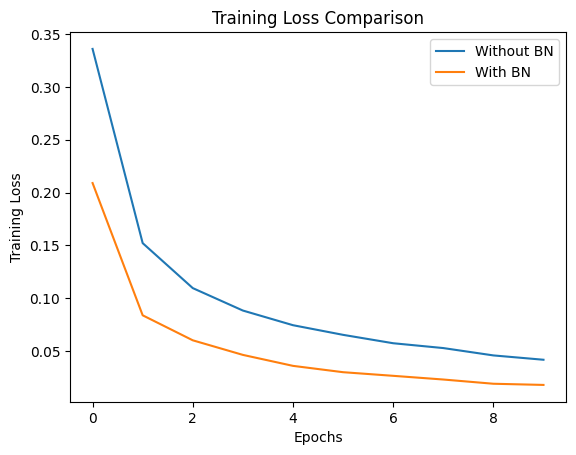

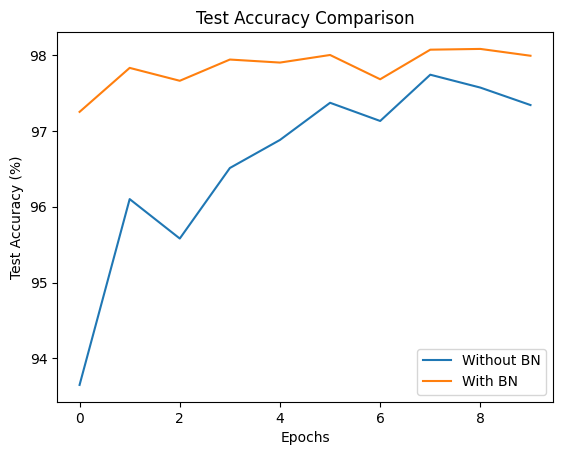

In [11]:
# Plot Loss
plt.plot(losses_no_bn, label="Without BN")
plt.plot(losses_bn, label="With BN")
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.legend()
plt.title("Training Loss Comparison")
plt.show()

# Plot Accuracy
plt.plot(acc_no_bn, label="Without BN")
plt.plot(acc_bn, label="With BN")
plt.xlabel("Epochs")
plt.ylabel("Test Accuracy (%)")
plt.legend()
plt.title("Test Accuracy Comparison")
plt.show()


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the model you trained earlier
model = load_model("mnist_bn_model.h5")  # save your model during training

# Load your own image
img = cv2.imread("digit.png")  # replace with your image path

# Convert to grayscale
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Resize to 28x28
img_resized = cv2.resize(img_gray, (28, 28))

# Invert colors if needed (MNIST has white digit on black background)
# Check your image. If digit is black on white, do this:
img_resized = 255 - img_resized  

# Normalize
img_normalized = img_resized / 255.0

# Reshape to (1,28,28,1)
img_input = img_normalized.reshape(1, 28, 28, 1)

# Predict
prediction = model.predict(img_input)
predicted_digit = np.argmax(prediction)

# Show result
plt.imshow(img_resized, cmap="gray")
plt.title(f"Predicted Digit: {predicted_digit}")
plt.axis("off")
plt.show()
